In [109]:
#https://www.mydatahack.com/building-alexnet-with-keras/

from keras import layers
from keras import preprocessing
from keras import models
from keras import optimizers
import cv2
import numpy as np

# #Initialize and create the CNN
#
TRAINING_PATH = 'chest_xray/train'
TESTING_PATH = 'chest_xray/test'
TARGET_SIZE = (200, 200)
INPUT_SHAPE = (200, 200, 3)
#
classifier = models.Sequential()
classifier.add(layers.Convolution2D(96, (11, 11), strides = 4, input_shape = INPUT_SHAPE, activation = 'relu'))
classifier.add(layers.BatchNormalization())
classifier.add(layers.MaxPooling2D(pool_size = (3,3), strides = 2))
classifier.add(layers.Convolution2D(256, (5, 5), padding = 'same', activation = 'relu'))
classifier.add(layers.BatchNormalization())
classifier.add(layers.MaxPooling2D(pool_size = (3,3), strides = 2))
classifier.add(layers.Convolution2D(384, (3, 3), activation = 'relu'))
classifier.add(layers.Convolution2D(384, (3, 3), activation = 'relu'))
classifier.add(layers.Convolution2D(256, (3, 3), activation = 'relu'))
classifier.add(layers.MaxPooling2D(pool_size = (3,3), strides = 2))
#
classifier.add(layers.Flatten())
#
classifier.add(layers.Dense(4096, activation = 'relu'))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(4096, activation = 'relu'))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(1000, activation = 'relu'))
classifier.add(layers.Dense(1, activation = 'sigmoid'))

#Compile classifier
opt = optimizers.Adam(learning_rate=.0001)
classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
#
# #Fitting CNN to the images
train_datagen = preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = preprocessing.image.ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(TRAINING_PATH, target_size=TARGET_SIZE, batch_size=32, class_mode='binary')
test_set = test_datagen.flow_from_directory(TESTING_PATH, target_size=TARGET_SIZE, batch_size=32, class_mode='binary')
classifier.fit_generator(training_set, steps_per_epoch=5216/32, epochs=25, validation_data=test_set, validation_steps = 624/32)
#classifier.fit_generator(training_set, steps_per_epoch=8000/32, epochs=30, validation_data=test_set, validation_steps = int(2000/32))



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
C:\Users\johns\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/25


In [2]:
# find the last layer conv layer by name from the summary
# save the model (comment out unless using)
#classifier.summary()
#classifier.save('saved_model_03')

INFO:tensorflow:Assets written to: saved_model_03\assets


In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras import backend as K
from tensorflow.keras import models
import matplotlib.pyplot as plt

# function for prepping an individual image for prediction
def preprocess_image(img):
    raw_img = cv2.imread(img)
    orig_size = raw_img.shape
    raw_img = cv2.resize(raw_img, (200, 200))
    np_img = np.asarray(raw_img)
    images = list()
    images.append(np_img / 255.0)
    images = np.array(images)
    images = images.reshape(-1, 200, 200, 3)
    return images, orig_size

In [2]:
# load model
classifier = models.load_model('saved_model_03')

# process and classify an image
raw_img = r'chest_xray\train\PNEUMONIA\person1_bacteria_1.jpeg'
#raw_img = r'chest_xray/train/NORMAL/IM-0115-0001.jpeg'
img, orig_size = preprocess_image(raw_img)
output = classifier.predict(img)
print(output[0][0])


0.999998


In [3]:
# saliency map functions (currently fixing the last one to superimpose image instead of printing side by side)
def build_model_produce_gradients(img, top):
    # build model with same input but with 2 outputs, 1 for the last layer
    last_layer = classifier.get_layer('conv2d_4')
    activations = models.Model([classifier.inputs], [last_layer.output, classifier.output]) 

    # print probabilities of cancer or not
    pred = classifier.predict(img)[0][0]
    print('predicted: ' + str(pred))
    class_label = round(pred)

    # track gradients
    with tf.GradientTape() as gtape:
        # run model on image get grads + preds, find grads from last layer to output
        last_layer_out, pred = activations(img)
        loss = pred[0]
        #print(loss)
        grads = gtape.gradient(loss, last_layer_out)
        # print(grads)

    return grads, activations, last_layer_out, class_label

def build_map(grads, last_layer_out, orig_size):
    # formula 1 global avg pooling
    alpha = tf.reduce_mean(grads, axis=[1,2])
    #print(alpha)

    # formula 2 activation maps x importance
    last_layer_out = np.transpose(last_layer_out[0])
    sal_map = np.tensordot(alpha, last_layer_out, axes=1)
    sal_map = tf.keras.activations.relu(sal_map)
    sal_map = np.array(sal_map[0])

    # resize image
    sal_map = cv2.rotate(sal_map, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
    sal_map = cv2.flip(sal_map, flipCode=0)
    sal_map = cv2.resize(sal_map, (orig_size[1], orig_size[0]))

    return sal_map

def saliency_map(raw_img, top):
    img, orig_size = preprocess_image(raw_img)
    grads, activations, last_layer_out, class_label = build_model_produce_gradients(img, top)
    img = img[0]
    heatmap = build_map(grads, last_layer_out, orig_size)
    heatmap = cv2.resize(heatmap, (200, 200))
    heatmap /= np.max(heatmap)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    combo = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
    plt.imshow(combo)

    # fig, arr = plt.subplots(1, 1)
    # arr.axis("off")
    # arr.imshow(heatmap)
    # plt.savefig('hm.png')

In [50]:
raw_img = 'chest_xray/test/PNEUMONIA/person8_virus_27.jpeg'
saliency_map(raw_img, 0)

predicted: 0.99815047
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-k8sx3e60\opencv\modules\core\src\arithm.cpp:693: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'cv::arithm_op'


predicted: 6.478358e-08


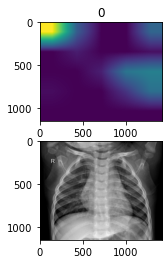

In [15]:
raw_img = 'chest_xray/train/NORMAL/IM-0117-0001.jpeg'
#raw_img = 'cat_and_dog.jpg'
saliency_map(raw_img, 0)